# Initialization through BNSE for SM kernel

Comparison between initializing sm kernel with different heuristics

* Random
* Lomb Scargle
* BNSE


Todo:
- Function to plot power spectral density

In [1]:
# import library if it is not installed
import sys
sys.path.insert(0, '../')

import mogptk
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.mixture import BayesianGaussianMixture as BGMM
from sklearn.mixture import GaussianMixture as GMM

%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
def get_param_across(model, name='mixture_means'):
    """
    Get all the name parameters across all components
    """
    params = [model.get_params()[q][name] for q in range(model.Q)]
    
    return np.array(params)

In [4]:
def plot_psd(model):
    """
    Plot power spectral density of 
    single output GP-SM
    """
    means = get_param_across(model, 'mixture_means').reshape(-1)
    weights = get_param_across(model, 'mixture_weights').reshape(-1)
    scales = get_param_across(model, 'mixture_scales').reshape(-1)
    
    # calculate bounds
    x_low = norm.ppf(0.001, loc=means, scale=scales).min()
    x_high = norm.ppf(0.99, loc=means, scale=scales).max()
    
    x = np.linspace(x_low, x_high + 1, 1000)
    psd = np.zeros_like(x)
    
    for q in range(model.Q):
        psd += weights[q] * norm.pdf(x, loc=means[q], scale=scales[q])
        
    psd *= 0.5
    if psd[x<0].size != 0:
        psd = psd + np.r_[psd[x<0][::-1], np.zeros((x>=0).sum())]
    
    plt.plot(x, psd, zorder=2, lw=2, c=sns.color_palette()[3])
    plt.stem(means, weights, use_line_collection=True)
    plt.xlim(0, x[-1] + 0.1)
    plt.yscale('log')
    plt.xlabel(r'$\omega$')
    plt.ylabel('PSD')

In [5]:
def experiment(x_train, y_train, x_pred, y_test, true_means, Q=3, n_trials=100):
    """
    Experiment with the 3 initializations for GP-SM
    
    The GP is fitted using the data and compared with the real
    parameters. This is done 'n_trial' times for each initialization 
    method.
    """
    # total error
    mae_param = np.zeros((3, n_trials))
    mae_pred = np.zeros((3, n_trials))
    
    x_pred = {0:x_pred}
    
    # create and train model
    data = mogptk.Data()
    data.add(x_train, y_train)
    
    init_methods = ['random', 'LS', 'BNSE']
    
    for i, method in enumerate(init_methods):
        for n in range(n_trials):
            # pick random seed
            seed = np.random.randint(1, int(1e8))
            np.random.seed(seed)
            
            model = mogptk.SM(data, Q=Q)
            model.init_params(method)
            model.train(maxiter=5000, disp=False)
            
            # param error
            means_pred = get_param_across(model, 'mixture_means').reshape(-1)
            mae_param[i, n] = np.abs(true_means - means_pred).sum()
            
            # pred error
            x_pred, y_pred, var_pred = model.predict(x_pred)
            mae_pred[i, n] = np.abs(y_test - y_pred[0]).mean()
            
    return mae_param, mae_pred

Create data for the experiment

In [6]:
# target freq to estimate
target_freqs = np.array([0.2, 1, 2])
target_amps = [1, 0.5, 0.5]

n_points = 500

t = np.linspace(0, 20, n_points)
y = np.zeros(n_points)

for i in range(3):
    y += target_amps[i] * np.sin(2 * np.pi * target_freqs[i] * t)
y_n = y + np.random.normal(scale=0.1, size=500)

# data class
data = mogptk.Data()

data.add(t, y_n, 'A')
data.remove_range('A', start=10.0, end=None)

Text(0.5, 1.0, 'BNSE PSD Estimate')

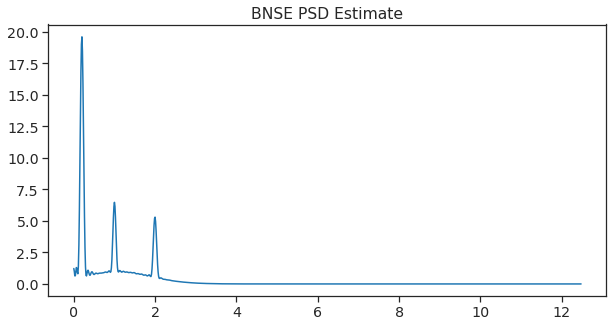

In [7]:
bnse = mogptk.bnse.bse(data.X[0], data.Y[0])
bnse.set_freqspace(data.get_nyquist_estimation()[0], dimension=1000)
bnse.train()
_, _, _, w, psd = bnse.compute_moments()

plt.plot(w, psd)
# plt.yscale('log')
plt.title('BNSE PSD Estimate')

In [8]:
# create model
model = mogptk.SM(data, Q=3)
# display(model.get_params())
print('Mixture means', get_param_across(model))
print('Mixture weights', get_param_across(model, 'mixture_weights'))

Mixture means [[1.40405538]
 [0.45001761]
 [0.55807139]]
Mixture weights [0.62809637 1.43727675 2.04705932]


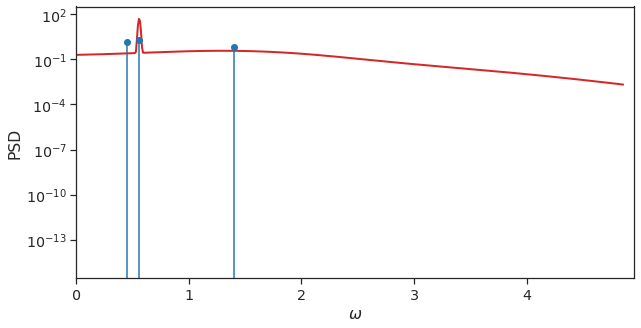

In [9]:
plot_psd(model)

Mixture means [[0.1997998]
 [0.998999 ]
 [1.997998 ]]
Mixture weights [0.48635229 0.55278951 0.67667216]


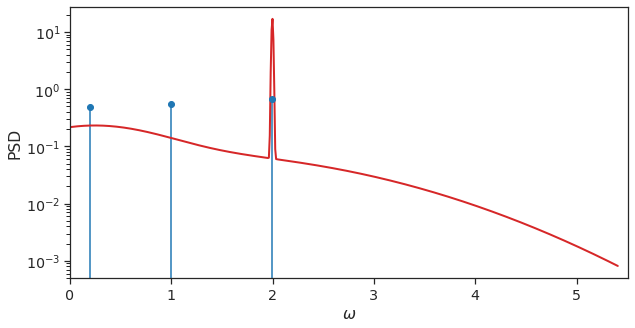

In [10]:
seed = np.random.randint(1, int(1e8))
np.random.seed(seed)

# initialize params
model.init_params(method='BNSE')
# display(model.get_params())
print('Mixture means', get_param_across(model))
print('Mixture weights', get_param_across(model, 'mixture_weights'))
plot_psd(model)

/home/felipe/anaconda3/lib/python3.6/site-packages/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -193.779703
  Number of iterations: 230
  Number of functions evaluations: 291
Mixture means [[0.19969533]
 [0.99878847]
 [1.99846534]]


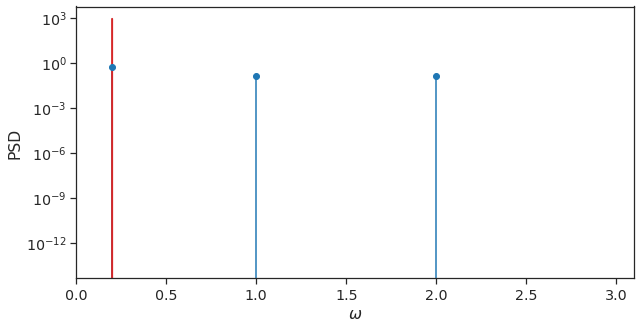

In [11]:
model.train(method='L-BFGS-B', maxiter=6000, disp=False)
plot_psd(model)
print('Mixture means', get_param_across(model))

Mixture means [[0.19969533]
 [0.99878847]
 [1.99846534]]


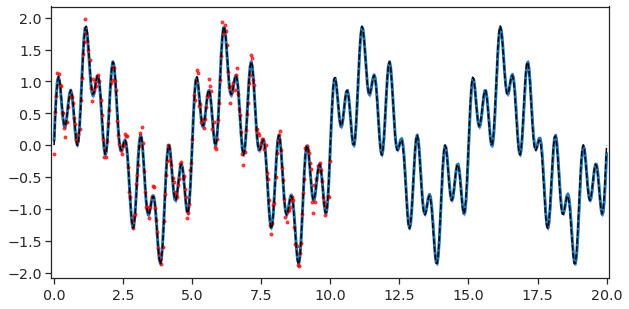

In [12]:
# x_pred = {0:np.linspace(0, 20, 300)}
x_pred = {0:t}
x_pred, y_pred, y_var = model.predict(x_pred)

print('Mixture means', get_param_across(model))

plt.plot(x_pred[0], y_pred[0], label='Pred', lw=3, zorder=2)
plt.plot(data.X[0], data.Y[0], '.r', alpha=0.7, zorder=2)
plt.plot(t, y, '--k', zorder=3)
plt.fill_between(x_pred[0],
                 y_pred[0] + 2 * np.sqrt(y_var[0]), 
                y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                alpha=0.3,
                zorder=1)
plt.xlim(-0.1, 20.1);

In [13]:
err_param, err_pred = experiment(t[:250], y_n[:250], t, y, target_freqs, Q=3, n_trials=100)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -61.761005
  Number of iterations: 54
  Number of functions evaluations: 67
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -125.704723
  Number of iterations: 64
  Number of functions evaluations: 85
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 199.500158
  Number of iterations: 41
  Number of functions evaluations: 55
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -59.949627
  Number of iterations: 49
  Number of functions evaluations: 61
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -59.108980
  Nu

KeyboardInterrupt: 

In [ ]:
err_param.mean(1), err_param.std(1)

In [ ]:
err_pred.mean(1), err_pred.std(1)


# Experiment 1: Mauna Loa

In [14]:
# dataset mauna loa
from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

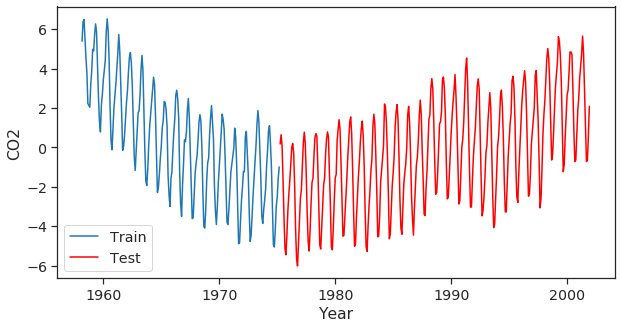

In [15]:
x, y_old = load_mauna_loa_atmospheric_co2()

from scipy.signal import detrend

y = detrend(y_old, axis=-1, type='linear')
trend = y_old - y
stop = 200

plt.plot(x[:stop], y[:stop], label='Train')
plt.plot(x[stop:], y[stop:], 'r', label='Test')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2');

Mixture means [[1.50502687]
 [0.59862476]
 [0.01773723]
 [1.07817262]
 [0.47848914]
 [1.27578853]
 [0.50228124]
 [0.24254706]
 [1.8392976 ]
 [0.69364851]]
Mixture weights [1.25431016 0.99719114 0.4048087  0.90362545 0.59303167 0.91823776
 0.39209909 0.20198209 0.0446964  1.61678776]


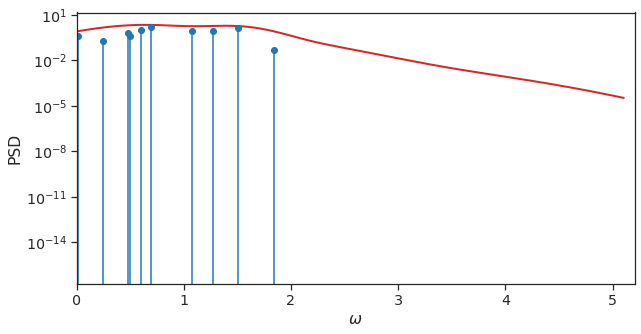

In [16]:
# add data
data = mogptk.Data()
data.add(x[:stop], y[:stop])

# create model
model = mogptk.SM(data, Q=10)
# display(model.get_params())
print('Mixture means', get_param_across(model))
print('Mixture weights', get_param_across(model, 'mixture_weights'))

plot_psd(model)

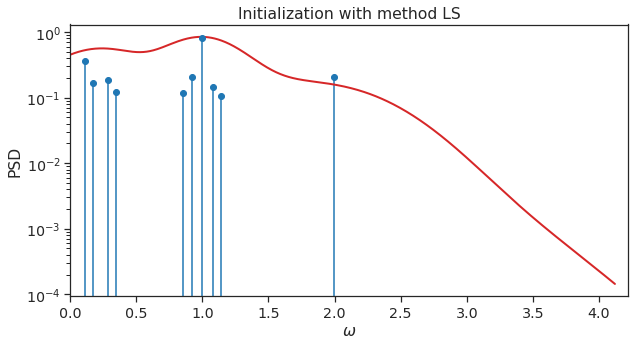

In [17]:
method = 'LS'

# model.init_params('random')
model.init_params(method)
plt.title('Initialization with method {}'.format(method))
plot_psd(model)

Building...
Optimizing...
         Current function value: 62.447891
         Iterations: 421
         Function evaluations: 598
         Gradient evaluations: 586
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 62.447891
  Number of iterations: 421
  Number of functions evaluations: 598
Done


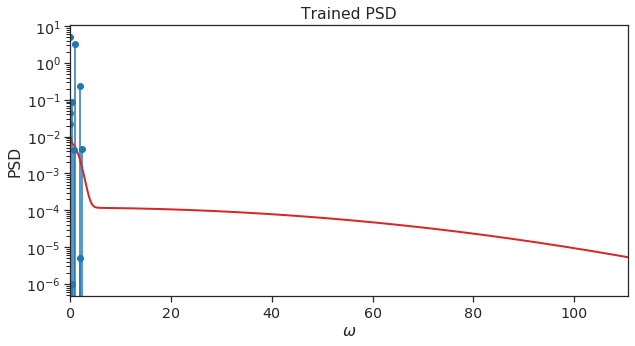

In [18]:
model.train(method='BFGS', maxiter=10000, disp=True, learning_rate=0.001)

plt.title('Trained PSD')
plot_psd(model)

CPU times: user 628 ms, sys: 84 ms, total: 712 ms
Wall time: 133 ms


Text(0, 0.5, 'CO2')

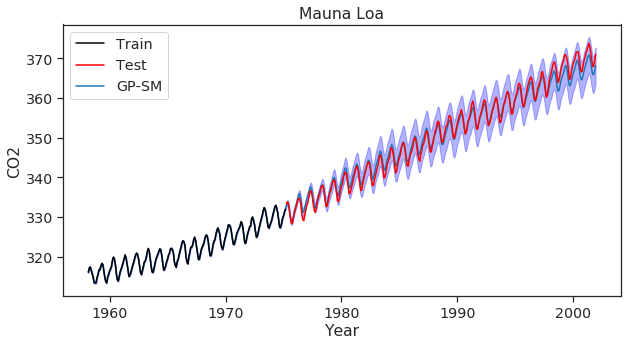

In [21]:
%%time 

# prediction
x_pred = {0:x}

x_pred, y_pred, y_var = model.predict(x_pred)

# plot
plt.plot(x[:stop], trend[:stop] + y[:stop], '-k', label='Train')
plt.plot(x[stop:], trend[stop:] + y[stop:], '-r', label='Test')
plt.plot(x_pred[0], trend + y_pred[0], lw=1.5, zorder=1, label='GP-SM')
plt.fill_between(x_pred[0],
                 trend + y_pred[0] + 2 * np.sqrt(y_var[0]),
                 trend + y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                 alpha=0.3,
                 zorder=1)
plt.legend()
plt.title('Mauna Loa')
plt.xlabel('Year')
plt.ylabel('CO2')

In [20]:
true_means = np.zeros(model.Q)
err_param, err_pred = experiment(x[:stop], y[:stop], x, y, true_means, Q=model.Q, n_trials=20)

/home/felipe/anaconda3/lib/python3.6/site-packages/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


KeyboardInterrupt: 

In [ ]:
err_pred.mean(1), err_pred.std(1)

In [ ]:
x_pred = {0:x}
x_pred, y_pred, y_var = model.predict(x_pred)

# plot
plt.plot(x[:stop], y[:stop], '-k', label='Train')
plt.plot(x[stop:], y[stop:], '-r', label='Test')
plt.plot(x_pred[0], y_pred[0], lw=1.5, zorder=1, label='GP-SM')
plt.fill_between(x_pred[0],
                 y_pred[0] + 2 * np.sqrt(y_var[0]),
                y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                alpha=0.3,
                zorder=1)
plt.title('Mauna Loa')
plt.xlabel('Year')
plt.ylabel('CO2')

# Jura single output


Save for later (until multi input])

In [ ]:
jura = pd.read_csv('data/jura.csv')

In [ ]:
jura.head()

# Airplane passangers

In [ ]:
air = np.loadtxt('data/Airline_passenger.csv')

stop = 96

data = mogptk.Data()
data.add(air[:stop, 0], air[:stop, 1])

plt.plot(data.X[0], data.Y[0])
plt.plot(air[stop:, 0], air[stop:, 1])

x = air[: ,0]
y = air[:, 1]

In [ ]:
model = mogptk.SM(data, Q=10)
plot_psd(model)

In [ ]:
method = 'BNSE'
model.init_params(method)
plot_psd(model)
plt.title('PSD initalized with {}'.format(method))

In [ ]:
model.train('Adam', maxiter=5000)
plot_psd(model)

In [ ]:
x_pred = {0:x}
x_pred, y_pred, y_var = model.predict(x_pred)

# plot
plt.plot(x[:stop], y[:stop], '-k', label='Train')
plt.plot(x[stop:], y[stop:], '-r', label='Test')
plt.plot(x_pred[0], y_pred[0], lw=1.5, zorder=1, label='GP-SM')
plt.fill_between(x_pred[0],
                 y_pred[0] + 2 * np.sqrt(y_var[0]),
                y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                alpha=0.3,
                zorder=1)
plt.title('Airline passanger')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Passanger');